In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
# Read in data from csv
df = pd.read_csv("solar_201502_201512_clean.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.head()

/var/folders/67/bc6pf3ys6nz54lvg3dk3gq5h0000gn/T/ipykernel_1471/928435783.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"])


,UTC,timestamp,kW-1,kW-2,kW-3,kW-4,kW-5,kW-6,kW-7,kW-8,kW-9,kW-10
0,1422766800,2015-02-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1422766860,2015-02-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1422766920,2015-02-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1422766980,2015-02-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1422767040,2015-02-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Exploration

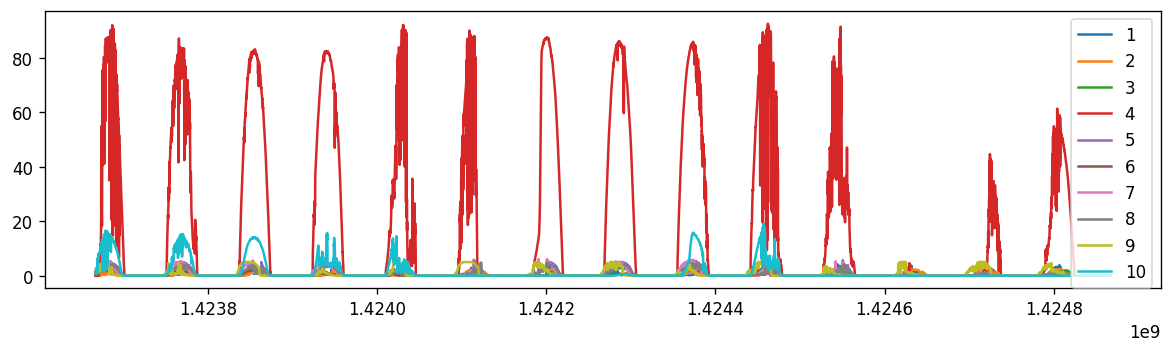

In [140]:
smaller_df = df.iloc[15000:35000]
x = smaller_df["UTC"]
for i in range(1, 11):
    plt.plot(x, smaller_df[f"kW-{i}"], label=f"{i}")
plt.legend()

# Define models

In [36]:
"""
Persistence model:
Uses the most recent value of a time series as the prediction
of the next value.

Inputs:
- time_series: <pandas DataFrame> Time series data with which
  we want to predict new data
- household_number: <int> Number representing which household's
  data we want to run linear regression on

Returns: <number> with predicted value of next time step
"""
def persistence(time_series, household_number):
    return time_series[f"kW-{household_number}"].iloc[-1]

print(persistence(df[:1000], 1))
print(df["kW-1"].iloc[999])

0.51255
0.51255


In [4]:
"""
Linear regression model:
Uses the linear trend over a window of recent data to predict 
the next value.

Inputs:
- time_series: <pandas DataFrame> Time series data with which
  we want to predict new data
- window_size: <int> Number of data inputs that we want to use
  for linear regression model
- household_number: <int> Number representing which household's
  data we want to run linear regression on

Returns: <number> with predicted value of next time step
"""
def linear_regression(time_series, window_size, household_number):
    x = time_series["UTC"].iloc[-window_size:]
    y = time_series[f"kW-{household_number}"].iloc[-window_size:]
    # print(y)

    # Create linear regression model
    x = np.array(x).reshape(-1, 1)
    model = LinearRegression().fit(x, y)

    # Plot the original data compared to linear regression model
    # (for testing purposes)
    # plt.plot(x, y, label="Original Data")
    # plt.plot(x, model.predict(x), label="Linear Regression Model")
    # plt.legend()
    # plt.show()

    # Predict next value
    next_time = np.array(x[-1] + 60).reshape(-1, 1)
    prediction = model.predict(next_time)
    return prediction[0]

# pred = linear_regression(df.iloc[:2500], 10, 1)
# print("Prediction:", pred)
# print("Actual:", df["kW-1"].iloc[2500])

In [143]:
"""
Autoregressive Integrated Moving Average (ARIMA)

Inputs:
- time_series: <pandas DataFrame> Time series data with which
  we want to predict new data
- p: <int>
- q: <int>
- household_number: <int>

Returns: <number> with predicted value of next time step
"""
def arima_model(time_series, p, q, household_number):
    x = time_series["UTC"]
    y = time_series[f"kW-{household_number}"]
    model = ARIMA(y, order=(p,q,0))
    model_fit = model.fit(method_kwargs={"warn_convergence": False})
    # print(type(model_fit))

    # Plot the original data compared to linear regression model
    # (for testing purposes)
    # plt.plot(x, y, label="Original Data")

    # residuals = pd.DataFrame(model_fit.resid)
    # residuals.plot()
    # # plt.plot(x, model_fit.predict(0, len(x)-1), label="Linear Regression Model")
    # plt.legend()
    # plt.show()

    # Predict next value
    prediction = model_fit.forecast().iloc[0]
    # print(prediction.iloc[0])
    return prediction

arima_model(df, 1, 2, 1)
# print(df["kW-1"].iloc[999])
# print(df["kW-1"].iloc[1000])

0.0

# 1. Determining the best window size for linear regression

In [72]:
# Use a seed for reproducible results
random.seed(0)

window_sizes = [2, 5, 10, 15, 30, 60, 120]

# Randomly select around 5% of the data to test
# The same random values will be used for all houses and 
# window sizes for consistency
loops = len(df) // 20
times = []
for _ in range(loops):
    times.append(random.randint(120, len(df)))

errors = [[] for _ in range(10)]

# Calculate mean absolute error for every combination of
# house number and window size
for window_size in window_sizes:
    for house_number in range(1, 11):    
        
        predictions = []
        true_values = []
        
        for time_to_predict in times:
            pred = linear_regression(df.iloc[:time_to_predict], window_size, house_number)
            actual = df[f"kW-{house_number}"].iloc[time_to_predict]
            predictions.append(pred)
            true_values.append(actual)

        error = metrics.mean_absolute_error(true_values, predictions)
        errors[house_number-1].append(error)
        print(f"MAE House {house_number}, Window Size {window_size}:", error)

MAE House 1, Window Size 2: 0.04231274138879339
MAE House 2, Window Size 2: 0.02476681777486947
MAE House 3, Window Size 2: 0.03169350247517646
MAE House 4, Window Size 2: 0.9590841034446196
MAE House 5, Window Size 2: 0.10260712345378412
MAE House 6, Window Size 2: 0.02395509046327301
MAE House 7, Window Size 2: 0.10257426422567162
MAE House 8, Window Size 2: 0.08390953005451246
MAE House 9, Window Size 2: 0.13052219450231178
MAE House 10, Window Size 2: 0.1877542316629952
MAE House 1, Window Size 5: 0.04341051299572649
MAE House 2, Window Size 5: 0.025974227215983425
MAE House 3, Window Size 5: 0.034912452005747496
MAE House 4, Window Size 5: 1.0161761328195758
MAE House 5, Window Size 5: 0.10143537554325394
MAE House 6, Window Size 5: 0.025361306172830177
MAE House 7, Window Size 5: 0.10157295793066795
MAE House 8, Window Size 5: 0.08732532203342117
MAE House 9, Window Size 5: 0.12354817245440475
MAE House 10, Window Size 5: 0.19405302051391243
MAE House 1, Window Size 10: 0.0520737

In [194]:
# Plot the results

house_errors = {
    "House 1": errors[0],
    "House 2": errors[1],
    "House 3": errors[2],
    "House 4": errors[3],
    "House 5": errors[4],
    "House 6": errors[5],
    "House 7": errors[6],
    "House 8": errors[7],
    "House 9": errors[8],
    "House 10": errors[9]
}
x = np.arange(len(window_sizes))  # the label locations
width = 0.09  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,8))

for attribute, measurement in house_errors.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, align="edge", label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Window Size')
ax.set_title('Error by Window Size')
ax.set_xticks(x + width*5, window_sizes)
ax.legend()

plt.show()

IndexError: list index out of range

It appears that the best window size is 2.

# 2. Determining p and q for ARIMA

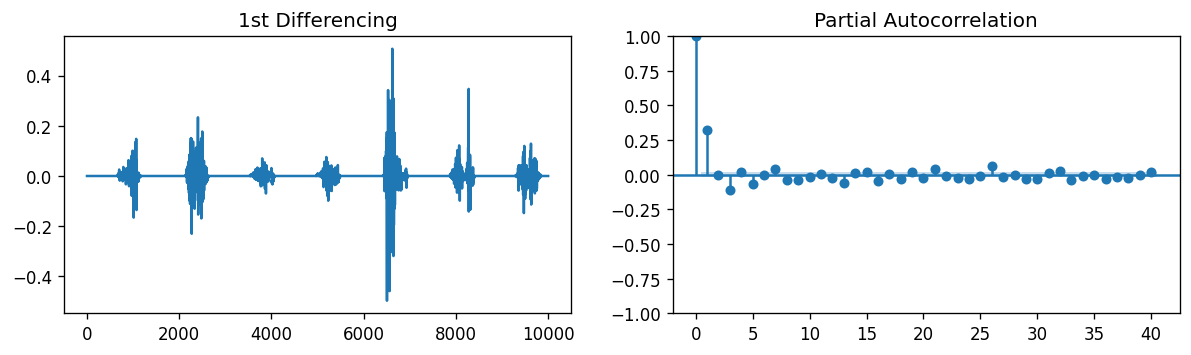

In [28]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df["kW-1"].iloc[:10000].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df["kW-1"].iloc[:10000].diff().dropna(), ax=axes[1])

plt.show()

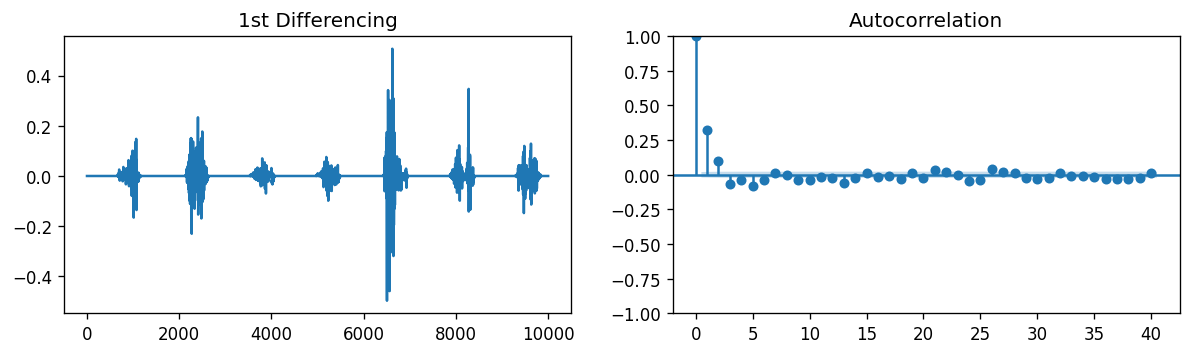

In [30]:
# ACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df["kW-1"].iloc[:10000].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df["kW-1"].iloc[:10000].diff().dropna(), ax=axes[1])

plt.show()

Seems like the best values are:
- p = 1
- q = 2

# 3. Comparing between different error metrics (RMSE, MAE, MAPE)

In [201]:
# Randomly generate 10 times to predict
# Lower number because ARIMA takes a while
loops = 10
times = []
for _ in range(loops):
    times.append(random.randint(120, len(df)))

# Each index represents a different error metric
# Each subarray contains 3 values, corresponding to the 3 models
errors = [[] for _ in range(3)]

# Optimal parameters:
window_size = 2
p = 1
q = 2

# Calculate error for every combination of
# house number and error metric
for error_metric in range(3):
    for model in range(3):
        total_error = []
        for house_number in range(1, 11):    
            
            predictions = []
            true_values = []
            
            for time_to_predict in times:
                pred = 0
                if model == 0:
                    pred = persistence(df.iloc[:time_to_predict], house_number)
                elif model == 1:
                    pred = linear_regression(df.iloc[:time_to_predict], window_size, house_number)
                else:
                    pred = arima_model(df.iloc[:time_to_predict], p, q, house_number)
                actual = df[f"kW-{house_number}"].iloc[time_to_predict]
                predictions.append(pred)
                true_values.append(actual)
            
            error = 0
            if error_metric == 0:
                error = metrics.mean_squared_error(true_values, predictions, squared=False)
            elif error_metric == 1:
                error = metrics.mean_absolute_error(true_values, predictions)
            else:
                error = metrics.mean_absolute_percentage_error(true_values, predictions)
            total_error.append(error)

        errors[error_metric].append(total_error)
        print(f"Metric {error_metric}, Model {model} average errors:", total_error)

Metric 0, Model 0 average errors: [0.09298540612012435, 0.04723104036863193, 0.041328550491478246, 0.37470657163624493, 0.3365507799280633, 0.026188636205168602, 0.03701319987474436, 0.02039685856130793, 0.27374388748909695, 0.0641063333172143]
Metric 0, Model 1 average errors: [0.2133684645579139, 0.07325656421292306, 0.015093017284879627, 0.5303144978678502, 0.3221909894520106, 0.008175330319320452, 0.01449915640125363, 0.016064183160623177, 0.16900109628219168, 0.03915299483580461]
Metric 0, Model 2 average errors: [0.20182904715026634, 0.11954599707639385, 0.019115993322342904, 0.4752582776569765, 0.35968596773314415, 0.009870894784067946, 0.016318871951173448, 0.014662193845892702, 0.3145748311811942, 0.05984108996247187]
Metric 1, Model 0 average errors: [0.04578666670000005, 0.020820000000000033, 0.01648500009999997, 0.1345400003000005, 0.11858499999999997, 0.011256666700000015, 0.023148333299999935, 0.012960000100000002, 0.1102566663, 0.03200500040000004]
Metric 1, Model 1 aver

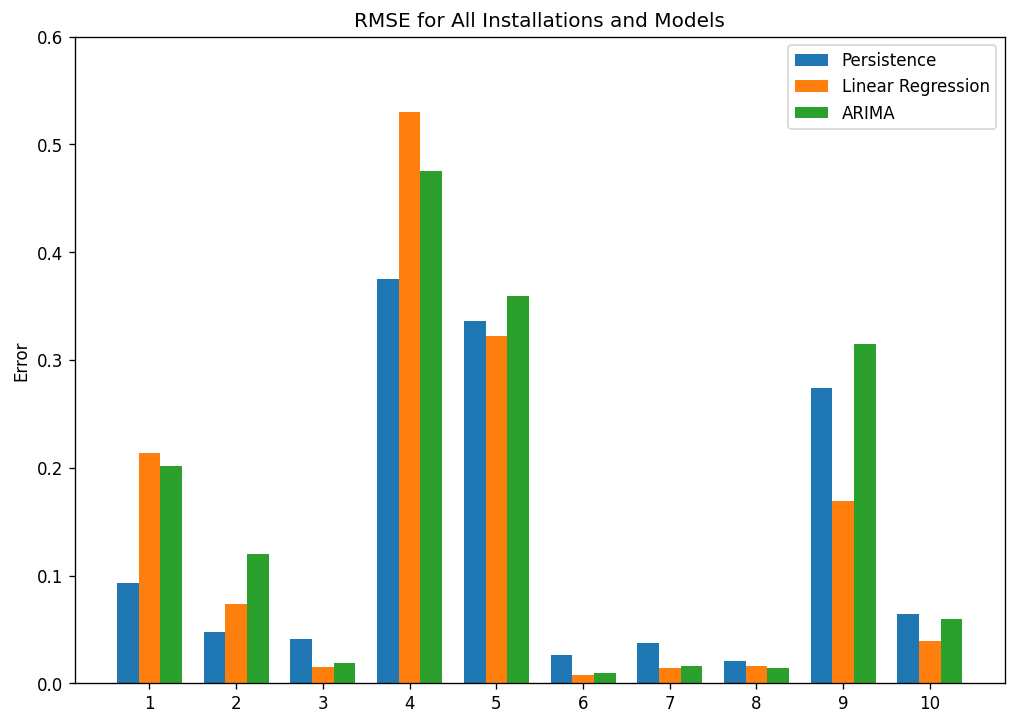

In [213]:
# Plot the results

metric = errors[0]
model_errors = {
    "Persistence": metric[0],
    "Linear Regression": metric[1],
    "ARIMA": metric[2]
}
x = np.arange(len(metric[0]))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,7))

for attribute, measurement in model_errors.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, align="edge", label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error')
ax.set_title('RMSE for All Installations and Models')
ax.set_xticks(x + width*1.5, np.arange(1,11))
ax.set_ylim(0, 0.6)
ax.legend()

plt.show()

# 5. Testing different resolutions

First, we will generate new CSVs of the data at the new resolutions

In [114]:
resolution = 60

# print(new_df)
new_values = []
current_row = []
values = np.zeros(10)
for i in range(len(df)):
    # Save timestamp data
    if (i+1) % resolution == 1:
        current_row.append(df["UTC"].iloc[i])
        current_row.append(df["timestamp"].iloc[i])
    
    # Sum up values column-wise
    values = np.sum([values, np.array(df.iloc[i, 2:])], axis=0)
    # print(np.array(df.iloc[i, 2:]))
    # print(values)

    # Once we've seen the number of rows we want in current resolution
    # add it to new values list
    if (i+1) % resolution == 0:
        # Add timestamp and save to list
        values = np.divide(values, resolution)
        current_row += list(values)
        new_values.append(current_row)

        # Reset values for next window
        values = np.zeros(10)
        current_row = []

# Convert new values to dataframe and save to file
new_df = pd.DataFrame(data=new_values, columns=["UTC", "timestamp", "kW-1", "kW-2", "kW-3", "kW-4", "kW-5", "kW-6", "kW-7", "kW-8", "kW-9", "kW-10"])
new_df.to_csv(f"resolution_{resolution}.csv")
new_df.head()

,UTC,timestamp,kW-1,kW-2,kW-3,kW-4,kW-5,kW-6,kW-7,kW-8,kW-9,kW-10
0,1422766800,2015-02-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1422770400,2015-02-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1422774000,2015-02-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1422777600,2015-02-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1422781200,2015-02-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
# Randomly generate 10 times to predict
# Lower number because ARIMA takes a while
loops = 10
times = []
for _ in range(loops):
    times.append(random.randint(120, len(df) // 60))

# Each index represents a different error metric
# Each subarray contains 3 values, corresponding to the 3 models
mae = [[] for _ in range(3)]
mape = [[] for _ in range(3)]

# Optimal parameters:
window_size = 2
p = 1
q = 2

# Calculate error for every combination of
# house number and resolution
resolutions = [2, 5, 10, 30, 60]
for resolution in resolutions:
    cur_df = pd.read_csv(f"resolution_{resolution}.csv")
    for model in range(3):
        total_error1 = []
        total_error2 = []
        for house_number in range(1, 11):    
            
            predictions = []
            true_values = []
            
            for time_to_predict in times:
                pred = 0
                if model == 0:
                    pred = persistence(cur_df.iloc[:time_to_predict], house_number)
                elif model == 1:
                    pred = linear_regression(cur_df.iloc[:time_to_predict], window_size, house_number)
                else:
                    pred = arima_model(cur_df.iloc[:time_to_predict], p, q, house_number)
                actual = cur_df[f"kW-{house_number}"].iloc[time_to_predict]
                predictions.append(pred)
                true_values.append(actual)
            
            error1 = metrics.mean_absolute_error(true_values, predictions)
            total_error1.append(error1)
            error2 = metrics.mean_absolute_percentage_error(true_values, predictions)
            total_error2.append(error2)

        mae[model].append(total_error1)
        mape[model].append(total_error2)
        print(f"Resolution {resolution}, Model {model} average errors:", total_error1)

Resolution 2, Model 0 average errors: [0.0005724999499999997, 0.0016608333499999988, 0.006624999950000009, 0.17680333249999974, 0.0037049999499999984, 0.0034941666500000077, 0.007098333299999995, 0.0007758333500000103, 0.004730000000000012, 0.013875833299999996]
Resolution 2, Model 1 average errors: [0.00047791672547403094, 0.0010054167000186271, 0.0031508332674647825, 0.06824041591923588, 0.0012937498992893954, 0.002027083299015657, 0.00397499993381932, 0.000812916748875861, 0.003707083350727336, 0.0077354167166529654]
Resolution 2, Model 2 average errors: [0.0012361662549797534, 0.0020317559493869307, 0.0007787870207239909, 0.04814108095105389, 0.0023639287332414107, 0.0006624073434052982, 0.0018806618789374535, 0.002415063357809483, 0.0009049910841848641, 0.024502023826859797]
Resolution 5, Model 0 average errors: [0.014607000059999996, 0.006885333300000004, 0.013126666659999998, 1.3459440000000011, 0.021571333279999983, 0.02056333334000001, 0.13159900000000008, 0.05432600001999999,

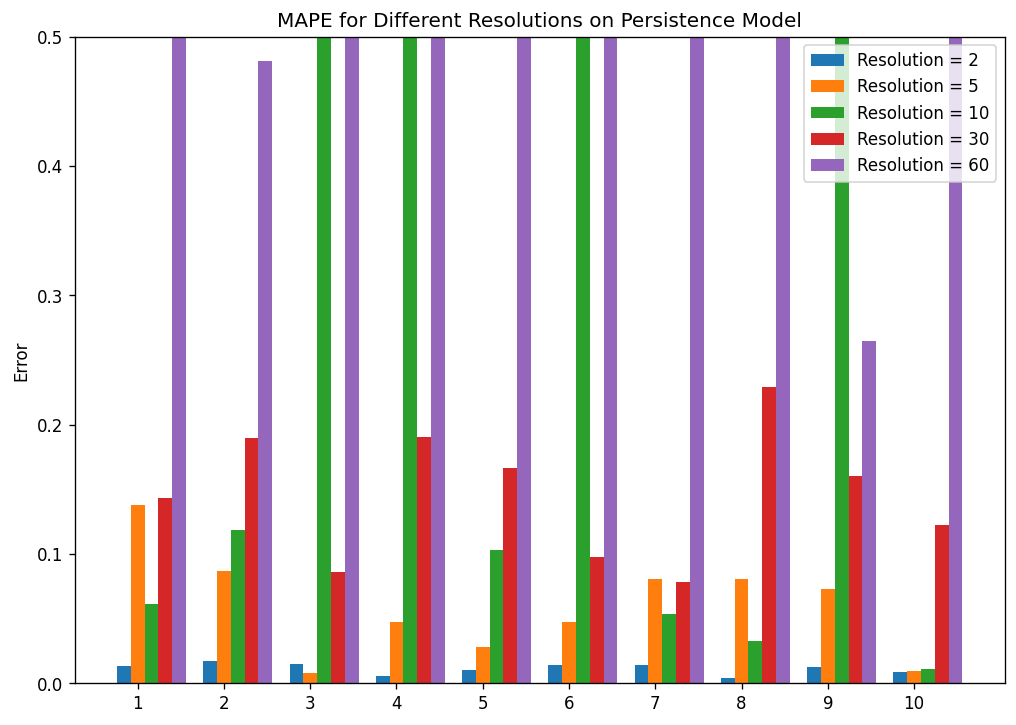

In [193]:
# Plot the results

model = mape[0]
model_errors = {
    "Resolution = 2": model[0],
    "Resolution = 5": model[1],
    "Resolution = 10": model[2],
    "Resolution = 30": model[3],
    "Resolution = 60": model[4]
}
x = np.arange(len(metric[0]))  # the label locations
width = 0.16  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,7))

for attribute, measurement in model_errors.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, align="edge", label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Error')
ax.set_title('MAPE for Different Resolutions on Persistence Model')
ax.set_xticks(x + width*1.5, np.arange(1,11))
ax.set_ylim(0, 0.5)
ax.legend()

plt.show()